In [32]:
data_dir = "../hover_net/CoNSeP"
save_data_dir = "./CoNSeP"

# Color Normalization

In [12]:
import sys
sys.path.append('Stain_Normalization')
import matplotlib.pyplot as plt
import glob,os
from Stain_Normalization import stainNorm_Vahadane
%matplotlib inline

target_im_path = "../hover_net/CoNSeP/Train/Images/train_6.png"
target_im = plt.imread(target_im_path)
train_option = "Train"
# train_option = "Test"

os.makedirs(save_data_dir, exist_ok=True)
os.makedirs(os.path.join(save_data_dir, train_option), exist_ok=True)

for im_file_path in glob.glob(os.path.join(data_dir, train_option,'Images','*.png')):
# im_file_path = 
    _, file_name = os.path.split(im_file_path)
    save_file_name = file_name[:-4]+".png"
    
    save_norm_dir = os.path.join(save_data_dir, train_option, 'Norms')
    os.makedirs(save_norm_dir, exist_ok = True)
    save_norm_file_path = os.path.join(save_norm_dir, save_file_name)
    
    if not os.path.exists(save_norm_file_path):
        im = plt.imread(im_file_path)[...,:3]

        # plt.imshow(im)

        cn = stainNorm_Vahadane.Normalizer()
        cn.fit(target_im)
        im_norm = cn.transform(im)
        plt.imsave(save_norm_file_path, im_norm)
#     print(save_norm_file_path)

# fig,axes = plt.subplots(1,2)
# axes[0].imshow(im)
# axes[1].imshow(im_norm)

# Extract Points

In [7]:
import scipy.io as sio
import numpy as np

labels_file = glob.glob(os.path.join(data_dir, train_option,'Labels','*.mat'))[0]
labels = sio.loadmat(labels_file)
inst_map = labels['inst_map']
type_map = labels['type_map']
inst_type = labels['inst_type']
inst_centroid = labels['inst_centroid']

In [34]:
from skimage.segmentation import find_boundaries
from skimage.filters import gaussian
from segmentation._watershed import watershed

SMOOTH = 1e-6

def validate_obj_params(obj_params=dict()):
    if not type(obj_params) is dict:
        raise TypeError('The obj_params is expected to be a dictionary not a {}'.format(type(obj_params)))
    if not 'sigma' in obj_params.keys():
        obj_params['sigma'] = 0.0
    if not 'compactness' in obj_params.keys():
        obj_params['compactness'] = 0.0
    if not 'alpha' in obj_params.keys():
        obj_params['alpha'] = 1.0
    return obj_params

def generate_dist(image, points, obj_params = dict()):
    obj_params = validate_obj_params(obj_params)
    points = np.array(points)
    pl = np.zeros(image.shape[:2])
    pl[points[:,1].round().astype(int),points[:,0].round().astype(int)] = np.arange(1,len(points)+1)
    image = gaussian(image,obj_params['sigma'], multichannel=True)
    
    return watershed(image, pl, compactness = obj_params['compactness'], method=True)

def generate_obj(image, points, obj_params = dict()):
    obj_params = validate_obj_params(obj_params)
    reg_split, dist = generate_dist(image,points,obj_params)
    bkg = find_boundaries(reg_split)
#     dist[bkg] = np.inf
    return np.exp(-obj_params['alpha']*dist**2), bkg, reg_split

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.round().astype(bool)
    labels = labels.round().astype(bool)
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    return 1-iou

def cross_entropy_numpy(outputs: np.array, labels: np.array):
    return np.mean(-labels*np.log(SMOOTH+outputs)-(1-labels)*np.log(SMOOTH+1-outputs))

In [112]:
import shutil
train_dir = os.path.join(save_data_dir,'Train')
train_norm_dir = os.path.join(save_data_dir,'Train','Norms')
os.makedirs(train_norm_dir, exist_ok = True)

for train_norm_path in glob.glob(os.path.join(train_dir,'*_norm.png')):
    new_train_norm_path = os.path.join(train_norm_dir, os.path.split(train_norm_path)[-1][:-9]+'.png')
    shutil.move(train_norm_path, new_train_norm_path)
#     print(new_train_norm_path)
# glob.glob(os.path.join(save_data_dir, 'Train', '*.png'))

In [119]:
def black_box_function(sigma, compactness, alpha):
    obj_params = dict()
    obj_params['sigma'] = sigma
    obj_params['compactness'] = compactness
    obj_params['alpha'] = alpha
    loss = 0.0
    for im_file_path in glob.glob(os.path.join(save_data_dir, 'Train', 'Norms', 'train_*.png')):
        im = plt.imread(im_file_path)
        file_name = os.path.split(im_file_path)[-1][:-4]
        labels = sio.loadmat(os.path.join(data_dir, 'Train', 'Labels', file_name+'.mat'))
        points = labels['inst_centroid']
        mask = labels['inst_map']>0
        obj, bkg = generate_obj(im, points, obj_params)
#         import pdb
#         pdb.set_trace()
        loss += cross_entropy_numpy(obj,mask.astype(float))+iou_numpy(obj,mask)
    
    return -loss

# test_im = plt.imread(os.path.join(data_dir, train_option, 'Images', 'test_1.png'))
# test_labels = sio.loadmat(os.path.join(data_dir, train_option, 'Labels', 'test_1.mat'))
# test_points = test_labels['inst_centroid']

In [120]:
from bayes_opt import BayesianOptimization
from haven import haven_utils as hu

pbounds = {'compactness':(0,0.001), 'alpha':(0,10), 'sigma':(0,3)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)


optimizer.maximize(
    init_points=10,
    n_iter=500,
)

hu.save_json('objectness_params_0.json', optimizer.max)

|   iter    |  target   |   alpha   | compac... |   sigma   |
-------------------------------------------------------------
|  1        | -21.78    |  4.17     |  0.000720 |  0.000343 |
|  2        | -20.26    |  3.023    |  0.000146 |  0.277    |
|  3        | -25.01    |  1.863    |  0.000345 |  1.19     |
|  4        | -18.68    |  5.388    |  0.000419 |  2.056    |
|  5        | -18.77    |  2.045    |  0.000878 |  0.08216  |
|  6        | -17.25    |  6.705    |  0.000417 |  1.676    |
|  7        | -41.61    |  1.404    |  0.000198 |  2.402    |
|  8        | -17.17    |  9.683    |  0.000313 |  2.077    |
|  9        | -31.81    |  8.764    |  0.000894 |  0.2551   |
|  10       | -65.5     |  0.3905   |  0.000169 |  2.634    |
|  11       | -17.4     |  6.271    |  0.000417 |  1.794    |
|  12       | -17.37    |  6.578    |  0.000420 |  1.901    |
|  13       | -17.69    |  9.727    |  0.000243 |  2.285    |
|  14       | -17.06    |  9.877    |  0.000402 |  2.015    |
|  15   

|  80       | -16.9     |  8.222    |  0.000476 |  2.179    |
|  81       | -16.81    |  4.583    |  0.000969 |  1.707    |
|  82       | -20.56    |  3.932    |  0.000683 |  0.4146   |
|  83       | -19.82    |  1.345    |  0.000938 |  0.02841  |
|  84       | -19.33    |  3.18     |  0.000806 |  1.882    |
|  85       | -31.4     |  1.768    |  0.000209 |  1.592    |
|  86       | -18.37    |  8.254    |  0.000119 |  1.675    |
|  87       | -18.77    |  7.102    |  0.000456 |  2.747    |
|  88       | -19.38    |  5.114    |  0.000710 |  2.799    |
|  89       | -16.8     |  5.957    |  0.000950 |  1.782    |
|  90       | -18.37    |  8.311    |  0.000840 |  1.612    |
|  91       | -44.93    |  0.3018   |  0.000242 |  0.3366   |
|  92       | -20.49    |  7.926    |  0.000140 |  2.377    |
|  93       | -19.07    |  6.743    |  0.000738 |  1.194    |
|  94       | -20.62    |  3.9      |  3.529e-0 |  0.4646   |
|  95       | -54.74    |  0.2542   |  3.611e-0 |  0.08947  |
|  96   

|  161      | -22.17    |  5.234    |  1.341e-0 |  0.365    |
|  162      | -17.29    |  5.332    |  0.000619 |  1.899    |
|  163      | -25.54    |  1.76     |  0.000604 |  1.597    |
|  164      | -17.45    |  9.777    |  0.00024  |  1.999    |
|  165      | -19.43    |  9.931    |  0.000245 |  1.33     |
|  166      | -139.8    |  0.007014 |  0.000121 |  1.473    |
|  167      | -41.52    |  1.351    |  0.000306 |  2.776    |
|  168      | -20.59    |  7.161    |  0.000400 |  0.9028   |
|  169      | -24.21    |  4.893    |  4.216e-0 |  1.786    |
|  170      | -25.14    |  6.988    |  0.000307 |  0.3921   |
|  171      | -19.29    |  4.992    |  0.000217 |  0.7609   |
|  172      | -19.02    |  6.745    |  8.054e-0 |  1.193    |
|  173      | -23.69    |  2.566    |  0.000691 |  2.207    |
|  174      | -29.67    |  2.343    |  0.000234 |  1.93     |
|  175      | -18.2     |  9.924    |  0.000192 |  1.582    |
|  176      | -23.39    |  8.393    |  0.000711 |  0.8872   |
|  177  

|  242      | -17.35    |  9.005    |  0.000862 |  2.008    |
|  243      | -17.21    |  9.428    |  0.000756 |  2.043    |
|  244      | -28.13    |  8.724    |  0.000148 |  0.05505  |
|  245      | -18.55    |  3.654    |  0.000559 |  1.521    |
|  246      | -17.04    |  6.601    |  0.000526 |  1.708    |
|  247      | -16.79    |  9.71     |  0.000471 |  2.262    |
|  248      | -28.14    |  2.059    |  0.000622 |  2.411    |
|  249      | -17.31    |  6.643    |  0.000916 |  1.657    |
|  250      | -17.61    |  8.307    |  0.000462 |  1.609    |
|  251      | -20.84    |  6.546    |  5.146e-0 |  1.75     |
|  252      | -18.97    |  9.926    |  0.000614 |  1.582    |
|  253      | -18.45    |  6.621    |  0.000177 |  1.634    |
|  254      | -17.45    |  6.623    |  0.000967 |  1.633    |
|  255      | -24.61    |  1.886    |  0.000654 |  1.661    |
|  256      | -25.46    |  8.539    |  0.000610 |  0.6626   |
|  257      | -20.35    |  9.875    |  1.78e-05 |  2.032    |
|  258  

|  323      | -19.6     |  2.003    |  0.000719 |  0.8652   |
|  324      | -17.28    |  7.949    |  0.000855 |  1.852    |
|  325      | -16.61    |  8.504    |  0.000732 |  2.272    |
|  326      | -16.75    |  6.448    |  0.000982 |  1.908    |
|  327      | -21.22    |  5.989    |  0.000279 |  2.509    |
|  328      | -40.0     |  0.583    |  0.000460 |  1.273    |
|  329      | -17.23    |  9.83     |  0.000295 |  2.128    |
|  330      | -16.96    |  6.926    |  0.000534 |  2.036    |
|  331      | -25.5     |  9.707    |  0.000840 |  0.9106   |
|  332      | -17.82    |  6.584    |  0.000289 |  1.729    |
|  333      | -28.71    |  3.8      |  7.886e-0 |  2.097    |
|  334      | -17.06    |  9.683    |  0.000659 |  2.075    |
|  335      | -18.72    |  6.447    |  0.000236 |  1.907    |
|  336      | -20.96    |  3.909    |  0.000574 |  0.2527   |
|  337      | -27.1     |  8.917    |  0.000615 |  0.5749   |
|  338      | -19.82    |  3.518    |  0.000337 |  0.393    |
|  339  

|  404      | -17.09    |  6.624    |  0.000506 |  1.681    |
|  405      | -24.55    |  5.758    |  0.000144 |  2.548    |
|  406      | -20.0     |  3.347    |  0.000756 |  0.362    |
|  407      | -22.56    |  8.924    |  1.847e-0 |  2.291    |
|  408      | -16.88    |  9.827    |  0.000489 |  2.132    |
|  409      | -17.2     |  6.694    |  0.000664 |  1.598    |
|  410      | -17.02    |  9.875    |  0.000468 |  2.033    |
|  411      | -17.65    |  8.647    |  0.000681 |  1.739    |
|  412      | -28.22    |  9.144    |  0.000338 |  0.433    |
|  413      | -17.0     |  9.73     |  0.000373 |  2.137    |
|  414      | -17.98    |  5.672    |  0.000284 |  1.326    |
|  415      | -17.28    |  6.743    |  0.000809 |  1.629    |
|  416      | -27.64    |  3.187    |  0.000184 |  2.061    |
|  417      | -19.23    |  6.264    |  6.412e-0 |  1.137    |
|  418      | -16.82    |  6.632    |  0.000725 |  1.81     |
|  419      | -19.22    |  2.425    |  0.000617 |  0.9872   |
|  420  

|  485      | -17.15    |  7.163    |  0.000677 |  2.602    |
|  486      | -19.88    |  7.786    |  0.000229 |  2.546    |
|  487      | -22.86    |  5.368    |  0.000243 |  0.2077   |
|  488      | -18.19    |  6.564    |  0.000232 |  1.72     |
|  489      | -16.85    |  6.271    |  0.000931 |  1.794    |
|  490      | -19.0     |  6.271    |  0.000190 |  1.796    |
|  491      | -17.42    |  6.631    |  0.000381 |  1.81     |
|  492      | -17.43    |  9.737    |  0.000838 |  2.079    |
|  493      | -17.25    |  4.58     |  0.000666 |  1.557    |
|  494      | -19.52    |  4.791    |  0.000282 |  1.727    |
|  495      | -17.17    |  6.71     |  0.000453 |  1.675    |
|  496      | -17.84    |  9.685    |  0.000998 |  2.079    |
|  497      | -16.95    |  9.831    |  0.000620 |  2.127    |
|  498      | -25.35    |  1.126    |  0.000849 |  1.074    |
|  499      | -19.26    |  5.277    |  0.000136 |  1.375    |
|  500      | -18.23    |  5.672    |  0.000227 |  1.324    |
|  501  

In [41]:
point_centroids[:,0]

array([ 51.2763466 , 855.21712538, 277.10416667, 423.08      ,
       968.0037037 , 878.95522388, 122.38076923, 935.8203125 ,
       180.66942149, 407.73333333, 255.7605042 , 952.81465517,
       296.22510823, 170.6826087 , 270.64628821, 131.46052632,
       785.26431718, 334.27753304, 231.30136986, 921.2718894 ,
        53.65277778, 916.92957746, 880.54976303, 128.03827751,
       299.37320574, 679.96634615, 762.43478261, 733.66990291,
       618.26108374,  65.9800995 , 733.2039801 , 744.48      ,
       300.9       , 939.96373057, 561.42105263, 262.99468085,
       315.9027027 , 102.96216216, 732.04347826,  35.96174863,
       156.02747253, 326.97802198, 982.8258427 , 212.9039548 ,
       211.31428571, 495.79651163,  16.19883041, 705.42941176,
       291.07647059,  91.41176471, 352.91566265, 244.42771084,
       479.96875   , 153.03125   , 134.43037975, 898.76433121,
       864.37748344,  32.52027027, 179.18243243, 231.35416667,
       862.88888889, 705.95      , 373.84558824,   4.32

In [45]:
import skimage.io as skio
import scipy.io as siio
from haven import haven_utils as hu
import numpy as np
import glob,os

option = 'Train'

obj_params = hu.load_json('objectness_params_0.json')

train_obj_dir = os.path.join(save_data_dir, option, 'Objs')
train_bkg_dir = os.path.join(save_data_dir, option, 'Bkgs')
train_pts_dir = os.path.join(save_data_dir, option, 'Pts')
train_gts_dir = os.path.join(save_data_dir, option, 'GTs')
train_rgs_dir = os.path.join(save_data_dir, option, 'Regions')
os.makedirs(train_obj_dir, exist_ok = True)
os.makedirs(train_bkg_dir, exist_ok = True)
os.makedirs(train_pts_dir, exist_ok = True)
os.makedirs(train_gts_dir, exist_ok = True)
os.makedirs(train_rgs_dir, exist_ok = True)
for im_file_path in glob.glob(os.path.join(save_data_dir, option, 'Norms', option.lower()+'_*.png')):
    points_in_type = dict()
    im = skio.imread(im_file_path)
    file_name = os.path.split(im_file_path)[-1][:-4]
    labels = siio.loadmat(os.path.join(data_dir, option, 'Labels', file_name+'.mat'))
    points = labels['inst_centroid']
    points_type = labels['inst_type']
    for i in np.arange(1,8):
        points_in_type[str(i)] = points[np.where(points_type==i)[0],:].tolist()
    mask = labels['type_map']
    obj, bkg, reg_split = generate_obj(im, points, obj_params)
    type_region_label = reg_split.copy()
    for point_type, point_centroids in points_in_type.items():
        if not len(point_centroids)==0:
            point_centroids = np.array(point_centroids,dtype = int)
            region_indexes = reg_split[point_centroids[:,1],point_centroids[:,0]]
            type_region_label[np.isin(reg_split, region_indexes)] = int(point_type)
    obj[bkg] = 0
    type_region_label[bkg] = 0
    skio.imsave(os.path.join(train_obj_dir, file_name+'.tif'), obj)
    skio.imsave(os.path.join(train_bkg_dir, file_name+'.tif'), bkg.astype(float))
    skio.imsave(os.path.join(train_gts_dir, file_name+'.tif'), mask.astype(float))
    skio.imsave(os.path.join(train_rgs_dir, file_name+'.tif'), type_region_label.astype(float))
    hu.save_json(os.path.join(train_pts_dir, file_name+'.json'), points_in_type)

/home/ubuntu/anaconda3/envs/TomProject/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: ./CoNSeP/Train/Regions/train_21.tif is a low contrast image
/home/ubuntu/anaconda3/envs/TomProject/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: ./CoNSeP/Train/GTs/train_5.tif is a low contrast image
/home/ubuntu/anaconda3/envs/TomProject/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: ./CoNSeP/Train/Regions/train_5.tif is a low contrast image
/home/ubuntu/anaconda3/envs/TomProject/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: ./CoNSeP/Train/GTs/train_25.tif is a low contrast image
/home/ubuntu/anaconda3/envs/TomProject/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: ./CoNSeP/Train/Regions/train_25.tif is a low contrast image


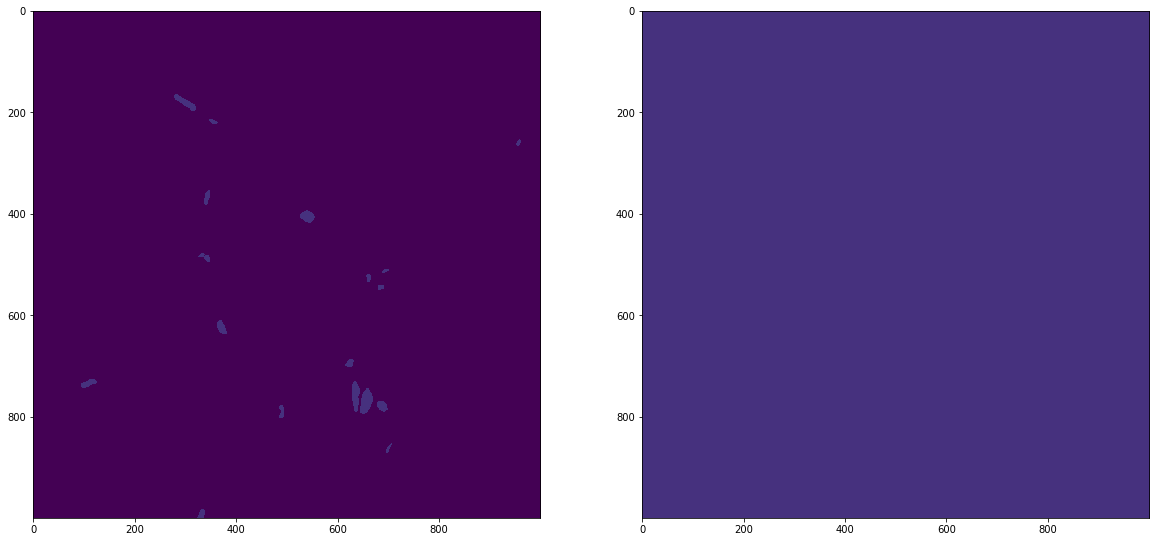

In [51]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(skio.imread('./CoNSeP/Train/GTs/train_5.tif'),vmax = 7, vmin = 0)
axes[1].imshow(skio.imread('./CoNSeP/Train/Regions/train_5.tif'),vmax = 7, vmin = 0)

In [161]:
classes = []
for labels_file_path in glob.glob(os.path.join(data_dir, 'Train', 'Labels', '*.mat')):
    labels = siio.loadmat(labels_file_path)
    classes += np.unique(labels["inst_type"]).tolist()

In [14]:
test_mask = skio.imread(os.path.join(train_obj_dir, 'train_5.tif'))
test_im = skio.imread(os.path.join(data_dir, 'Train', 'Images', 'train_5.png'))

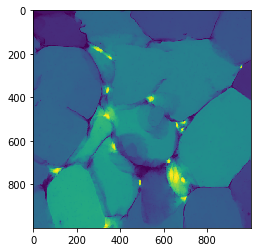

In [15]:
plt.imshow(test_mask)

In [8]:
test = 'test'
test is 'test'

True

In [33]:
import os,glob
import shutil

val_dir = '../hover_net/CoNSeP/Validation'
tst_dir = '../hover_net/CoNSeP/Test'
os.makedirs(val_dir, exist_ok = True)

object_types = [os.path.split(path)[-1] for path in glob.glob('../hover_net/CoNSeP/Test/*')]

for i in range(7):
    for object_ in object_types:
        if object_ in 'Labels':
            suffix = 'mat'
        else:
            suffix = 'png'
            
        os.makedirs(os.path.join(val_dir, object_), exist_ok = True)
        src_path = os.path.join(tst_dir, object_, 'test_{0}.{1}'.format(i+1, suffix))
        if os.path.exists(src_path):
            tgt_path = os.path.join(val_dir, object_, 'validation_{0}.{1}'.format(i+1, suffix))
            print('moving {0} to {1}'.format(src_path,tgt_path))
            shutil.move(src_path, tgt_path)

moving ../hover_net/CoNSeP/Test/Overlay/test_1.png to ../hover_net/CoNSeP/Validation/Overlay/validation_1.png
moving ../hover_net/CoNSeP/Test/Overlay/test_2.png to ../hover_net/CoNSeP/Validation/Overlay/validation_2.png
moving ../hover_net/CoNSeP/Test/Overlay/test_3.png to ../hover_net/CoNSeP/Validation/Overlay/validation_3.png
moving ../hover_net/CoNSeP/Test/Overlay/test_4.png to ../hover_net/CoNSeP/Validation/Overlay/validation_4.png
moving ../hover_net/CoNSeP/Test/Overlay/test_5.png to ../hover_net/CoNSeP/Validation/Overlay/validation_5.png
moving ../hover_net/CoNSeP/Test/Overlay/test_6.png to ../hover_net/CoNSeP/Validation/Overlay/validation_6.png
moving ../hover_net/CoNSeP/Test/Overlay/test_7.png to ../hover_net/CoNSeP/Validation/Overlay/validation_7.png


In [30]:
src_path

'../hover_net/CoNSeP/Test/Pts/test_7.json'

In [34]:
import os,glob
import shutil

val_dir = '../hover_net/CoNSeP/Validation'
tst_dir = '../hover_net/CoNSeP/Test'
os.makedirs(val_dir, exist_ok = True)

object_types = [os.path.split(path)[-1] for path in glob.glob('../hover_net/CoNSeP/Test/*')]

for i in range(7):
    for object_ in object_types:
        if object_ in 'Labels':
            suffix = 'mat'
        else:
            suffix = 'png'
            
        os.makedirs(os.path.join(val_dir, object_), exist_ok = True)
        src_path = os.path.join(tst_dir, object_, 'test_{0}.{1}'.format(i+8, suffix))
        if os.path.exists(src_path):
            tgt_path = os.path.join(tst_dir, object_, 'test_{0}.{1}'.format(i+1, suffix))
            print('moving {0} to {1}'.format(src_path,tgt_path))
            shutil.move(src_path, tgt_path)

moving ../hover_net/CoNSeP/Test/Labels/test_8.mat to ../hover_net/CoNSeP/Test/Labels/test_1.mat
moving ../hover_net/CoNSeP/Test/Overlay/test_8.png to ../hover_net/CoNSeP/Test/Overlay/test_1.png
moving ../hover_net/CoNSeP/Test/Images/test_8.png to ../hover_net/CoNSeP/Test/Images/test_1.png
moving ../hover_net/CoNSeP/Test/Labels/test_9.mat to ../hover_net/CoNSeP/Test/Labels/test_2.mat
moving ../hover_net/CoNSeP/Test/Overlay/test_9.png to ../hover_net/CoNSeP/Test/Overlay/test_2.png
moving ../hover_net/CoNSeP/Test/Images/test_9.png to ../hover_net/CoNSeP/Test/Images/test_2.png
moving ../hover_net/CoNSeP/Test/Labels/test_10.mat to ../hover_net/CoNSeP/Test/Labels/test_3.mat
moving ../hover_net/CoNSeP/Test/Overlay/test_10.png to ../hover_net/CoNSeP/Test/Overlay/test_3.png
moving ../hover_net/CoNSeP/Test/Images/test_10.png to ../hover_net/CoNSeP/Test/Images/test_3.png
moving ../hover_net/CoNSeP/Test/Labels/test_11.mat to ../hover_net/CoNSeP/Test/Labels/test_4.mat
moving ../hover_net/CoNSeP/Tes

In [60]:
import torch
test = torch.rand(4,3,5)

In [67]:
from torch.nn import functional as F

In [70]:
test_bool = test>0.5

In [72]:
~test_bool

tensor([[[False, False, False, False, False],
         [ True, False, False, False,  True],
         [False,  True, False,  True, False]],

        [[False, False, False,  True,  True],
         [ True, False,  True, False, False],
         [ True, False,  True,  True, False]],

        [[ True,  True, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False,  True,  True]],

        [[False, False, False, False,  True],
         [ True, False, False,  True,  True],
         [ True, False, False, False,  True]]])

In [79]:
import scipy.io as siio

In [87]:
types = []
for mat_file in glob.glob('../hover_net/CoNSeP/**/Labels/*.mat'):
    test = siio.loadmat(mat_file)
    types.append(np.unique(test['type_map']).tolist())

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'type_map', 'inst_type', 'inst_centroid'])

In [90]:
types_ = []
for type_ in types:
    types_+= type_

In [93]:
types

[[0.0, 1.0, 2.0, 5.0, 7.0],
 [0.0, 2.0, 5.0, 6.0],
 [0.0, 1.0, 2.0, 5.0, 6.0, 7.0],
 [0.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 2.0, 5.0, 6.0],
 [0.0, 1.0, 2.0, 6.0, 7.0],
 [0.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 4.0, 5.0],
 [0.0, 2.0, 3.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 2.0, 6.0],
 [0.0, 2.0, 5.0],
 [0.0, 2.0, 5.0, 7.0],
 [0.0, 1.0, 2.0, 5.0, 6.0],
 [0.0, 2.0, 3.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0],
 [0.0, 1.0],
 [0.0, 1.0, 2.0, 5.0, 6.0, 7.0],
 [0.0, 2.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0, 7.0],
 [0.0, 1.0, 2.0, 3.0, 5.0, 7.0],
 [0.0, 2.0, 5.0, 6.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0, 5.0, 6.0, 7.0],
 [0.0, 1.0, 2.0, 5.0, 7.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 2.0, 5.0, 6.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 2.0, 3.0, 4.0, 5.0, 7.0],
 [0.0, 1.0, 2.0, 4.0, 5.0],
 [0.0, 2.0, 3.0, 5.0],
 [0.0, 1.0, 2.0, 5.0, 7.0],
 [0.0, 2.0, 5.0,